# PyKOALA Data Reduction Sequence (Science data)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import os
from pykoala import __version__
import warnings

# You may want to comment the following line
warnings.filterwarnings("ignore")

# pyKOALA version
print("pyKOALA version: ", __version__)

pyKOALA version:  0.14.1+17.g0f0d6c9.dirty


In [3]:
from pykoala.instruments.koala_ifu import koala_rss
from pykoala.corrections.atmospheric_corrections import AtmosphericExtCorrection, get_adr
from pykoala.corrections.throughput import Throughput, ThroughputCorrection
from pykoala.cubing import build_cube, build_wcs

atm_ext_corr = AtmosphericExtCorrection.from_text_file(
    AtmosphericExtCorrection.default_extinction)

[pykoala.correction.AtmosphericExtinction] 2024/08/18 10:13|INFO> Initialising correction


### Throughput correction

In [4]:
flat_rss = [koala_rss("data/combined_skyflat_red.fits")]
throughput_corr = ThroughputCorrection.from_rss(flat_rss, clear_nan=True, medfilt=10)

[pykoala] 2024/08/18 10:13|INFO> 
> Reading KOALA RSS file combined_skyflat_red.fits
[pykoala] 2024/08/18 10:13|INFO> Number of fibres in this RSS =1000No. of good fibres = 986No. of bad fibres = 14
[pykoala] 2024/08/18 10:13|INFO> Bad fibres = [109, 110, 235, 424, 574, 607, 675, 714, 721, 722, 723, 793, 950, 951]
Applying median filter (size=10 px)


### Telluric correction

We will use the correction function derived during the standard stars reduction sequence.

In [5]:
from pykoala.corrections.sky import TelluricCorrection

telluric_corr = TelluricCorrection.from_text_file('products/telluric_correction_red.dat')

[pykoala] 2024/08/18 10:13|INFO> Initialising telluric correction from text file


## Load the science data

In [6]:
sci_rss = []
aaomega_arms = {'blue': 1, 'red': 2}
# Choose which arm of the spectrograph is going to be used
arm = 'blue'
path_to_data = 'data'

adr_set = []

#for i in [31, 32, 33]:
for i in [34, 35, 36]:
    filename = f"data/27feb200{i}red.fits"
    rss = koala_rss(filename)

    rss = throughput_corr.apply(rss)
    rss = atm_ext_corr.apply(rss)
    rss = telluric_corr.apply(rss)
    # Telluric
    # Sky
    
    adr_ra, adr_dec, fig = get_adr(rss, plot=True)
    adr_set.append([adr_ra, adr_dec])
    sci_rss.append(rss)

[pykoala] 2024/08/18 10:13|INFO> 
> Reading KOALA RSS file 27feb20034red.fits
[pykoala] 2024/08/18 10:13|INFO> Number of fibres in this RSS =1000No. of good fibres = 986No. of bad fibres = 14
[pykoala] 2024/08/18 10:13|INFO> Bad fibres = [109, 110, 235, 424, 574, 607, 675, 714, 721, 722, 723, 793, 950, 951]
[pykoala.correction.AtmosphericExtinction] 2024/08/18 10:13|INFO> Applying model-based extinction correction toData Container (1.03 airmass)
[pykoala.correction.TelluricCorretion] 2024/08/18 10:13|INFO> Applying telluric correction
[pykoala] 2024/08/18 10:13|INFO> 
> Reading KOALA RSS file 27feb20035red.fits
[pykoala] 2024/08/18 10:13|INFO> Number of fibres in this RSS =1000No. of good fibres = 986No. of bad fibres = 14
[pykoala] 2024/08/18 10:13|INFO> Bad fibres = [109, 110, 235, 424, 574, 607, 675, 714, 721, 722, 723, 793, 950, 951]
[pykoala.correction.AtmosphericExtinction] 2024/08/18 10:13|INFO> Applying model-based extinction correction toData Container (1.02 airmass)
[pykoala.

## Astrometry Corrections and Registration

### Image Cross-correlation

The most sofisticated method to perform the registration of extended sources included in pyKOALA is based on the cross-correlation of two images.
### Centroid finding

A simple approach to find the offset between the different RSS is to find the center of light of the images (assuming that they contain the same sources).

In [7]:
from pykoala.corrections.astrometry import AstrometryCorrection

astrom_corr = AstrometryCorrection()
offsets, fig = astrom_corr.register_crosscorr(sci_rss, qc_plot=True)
for offset in offsets:
    print("Offset (ra, dec) in arcsec: ", offset[0].to('arcsec'), offset[1].to('arcsec'))

[pykoala.correction.Astrometry] 2024/08/18 10:13|INFO> Performing image cross-correlation
[pykoala] 2024/08/18 10:13|INFO> [Cubing] Starting cubing process
[pykoala] 2024/08/18 10:13|INFO> [Cubing] Initialising GaussianKernel
 Scale: 3.3 (pixels)
 Truncation radius: 2.0
[pykoala] 2024/08/18 10:13|INFO> [Cubing] Initialising new datacube with dimensions: (2048, 86, 164)
[pykoala] 2024/08/18 10:13|INFO> [Cubing] Stacking individual cubes using mad_clipping
[pykoala] 2024/08/18 10:13|INFO> [Cubing] Additonal arguments for stacking: {}
[pykoala.pykoala.cube] 2024/08/18 10:13|INFO> WARNING: No `wavelength` vector supplied; creating empty `SpectraContainer`
[pykoala.pykoala.cube] 2024/08/18 10:13|INFO> [Cube] Looking for information in the primary header
[pykoala.pykoala.cube] 2024/08/18 10:13|INFO> [Cube] Constructing wavelength array
[pykoala] 2024/08/18 10:13|INFO> [Cubing] Starting cubing process
[pykoala] 2024/08/18 10:13|INFO> [Cubing] Initialising GaussianKernel
 Scale: 3.3 (pixels)
 

<Figure size 640x480 with 0 Axes>

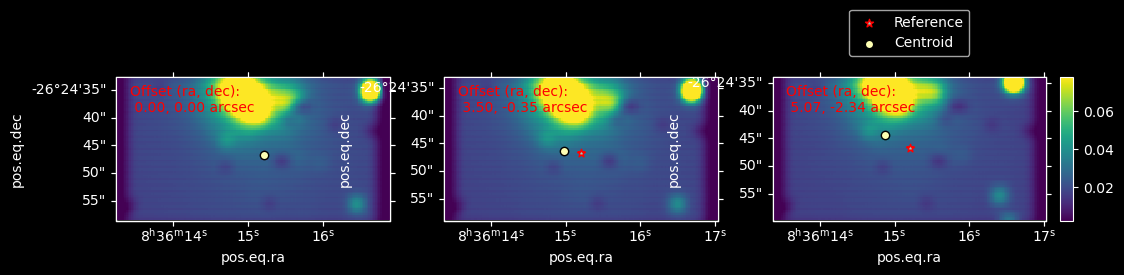

In [8]:
fig

For interpolating RSS data into a 3D datacube we will make use of the function *build_cube*. This method requires as input:
- A list of RSS objects. 
- The desired dimensions of the cube expressed as a 2-element tuple, corresponding to (ra, dec) in arcseconds.
- The pixel size of the cube in arcseconds.
- A list containing the ADR correction for every RSS (it can contain None) in the form: [(ADR_ra_1, ADR_dec_1), (ADR_ra_2, ADR_dec_2), (None, None)].
- Additional information to be included in *cube_info*

In [9]:
datacube_shape = (sci_rss[0].wavelength.size, 40, 60)
ref_position = (sci_rss[0].wavelength[0], np.mean(sci_rss[0].info['fib_ra']), np.mean(sci_rss[0].info['fib_dec']))  # (deg, deg)
spatial_pixel_size = 1.0 / 3600  # (deg)
spectral_pixel_size = sci_rss[0].wavelength[1] - sci_rss[0].wavelength[0]  # (angstrom)

print(f"Creating a WCS with\n position: {ref_position}\n Spatial pixel size: {spatial_pixel_size}\n Spectral pixel size: {spectral_pixel_size}")

wcs = build_wcs(datacube_shape=datacube_shape,
                reference_position=ref_position,
                spatial_pix_size=spatial_pixel_size,
                spectra_pix_size=spectral_pixel_size,
            )

cube = build_cube(rss_set=sci_rss,
                  wcs=wcs,
                  adr_set=adr_set,
                  kernel_size_arcsec=1.0,
                  cube_info=dict(name=rss.info['name'].split(' ')[0]))

Creating a WCS with
 position: (6080.95886230418, 129.06270331213648, -26.412717838960667)
 Spatial pixel size: 0.0002777777777777778
 Spectral pixel size: 1.5751823123400754
[pykoala] 2024/08/18 10:14|INFO> [Cubing] Starting cubing process
[pykoala] 2024/08/18 10:14|INFO> [Cubing] Initialising GaussianKernel
 Scale: 1.0 (pixels)
 Truncation radius: 2.0
[pykoala] 2024/08/18 10:14|INFO> [Cubing] Initialising new datacube with dimensions: (2048, 60, 40)
[pykoala] 2024/08/18 10:14|INFO> [Cubing] Stacking individual cubes using mad_clipping
[pykoala] 2024/08/18 10:14|INFO> [Cubing] Additonal arguments for stacking: {}
[pykoala.pykoala.cube] 2024/08/18 10:14|INFO> WARNING: No `wavelength` vector supplied; creating empty `SpectraContainer`
[pykoala.pykoala.cube] 2024/08/18 10:14|INFO> [Cube] Looking for information in the primary header
[pykoala.pykoala.cube] 2024/08/18 10:14|INFO> [Cube] Constructing wavelength array


## Sky substraction

In [10]:
import pykoala.corrections.sky as sky
import importlib
importlib.reload(sky)

skymodel = sky.SkyFromObject(cube, bckgr_estimator='mad', source_mask_nsigma=3, remove_cont=False)
skycorrection = sky.SkySubsCorrection(skymodel)
cube, _ = skycorrection.apply(cube)

[pykoala] 2024/08/18 10:14|INFO> Creating SkyModel from input Data Container
[pykoala] 2024/08/18 10:14|INFO> Estimating sky background contribution...
[pykoala] 2024/08/18 10:14|INFO> Pre-estimating background using all data
[pykoala] 2024/08/18 10:14|INFO> Applying sigma-clipping mask (n-sigma=3)
[pykoala.correction.SkyCorrection] 2024/08/18 10:14|INFO> Applying sky subtraction
[pykoala.pykoala.cube] 2024/08/18 10:14|INFO> [Cube] Updating HDUL INTENSITY
[pykoala.pykoala.cube] 2024/08/18 10:14|INFO> [Cube] Updating HDUL variance


## Absolute flux calibration

[pykoala.correction.FluxCalibration] 2024/08/18 10:14|INFO> Initialising Flux Calibration (Spectral Throughput)


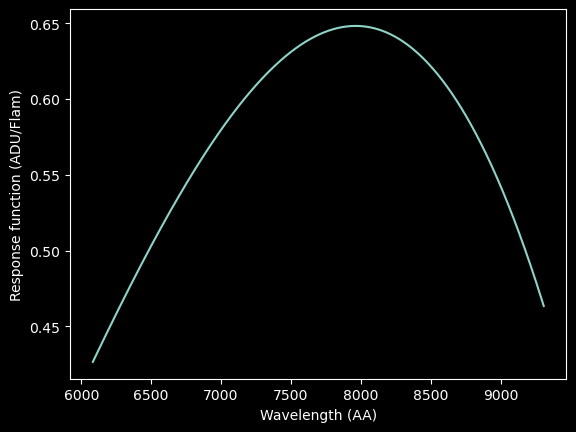

[pykoala.pykoala.cube] 2024/08/18 10:14|INFO> [Cube] Updating HDUL INTENSITY
[pykoala.pykoala.cube] 2024/08/18 10:14|INFO> [Cube] Updating HDUL variance
[QCPLOT] Cube QC plot for:  He2-10
Enrties found: [<pykoala.data_container.HistoryRecord object at 0x7f4b080c90d0>]


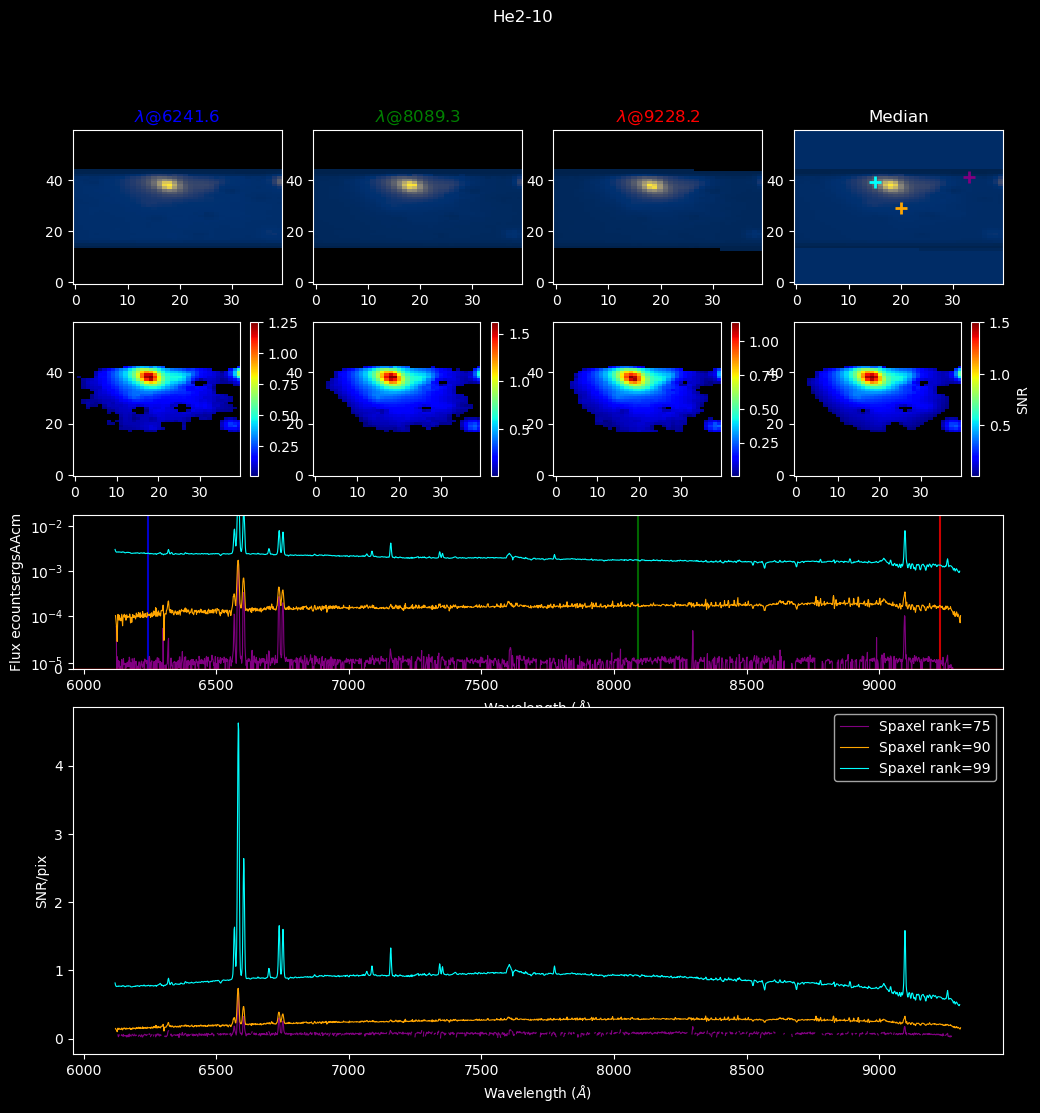

In [11]:
from pykoala.corrections.flux_calibration import FluxCalibration
from pykoala.plotting.qc_plot import qc_cube

fcal = FluxCalibration.from_text_file('products/response_HILT600_transfer_function.dat')

plt.figure()
plt.plot(fcal.response_wavelength, fcal.response)
plt.xlabel("Wavelength (AA)")
plt.ylabel("Response function (ADU/Flam)")
plt.show()

cube = fcal.apply(cube)

fig = qc_cube(cube)
plt.show(plt.figure(fig))


In [12]:
# Save the data cube
cube.to_fits("products/Henize_2-10_cube_no_sky.fits.gz")

[pykoala.pykoala.cube] 2024/08/18 10:14|INFO> [Cube] Cube saved at:
 products/Henize_2-10_cube_no_sky.fits.gz
